In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [27]:

# print(dt)
# plt.plot(t, senal, label = 'Senal sintetica ')
# # plt.plot(t, senal_ruido, label = 'Senal sintetica')
# plt.plot(t, filtered, label = 'Senal Filtrada')
# plt.legend()
# plt.show()

In [28]:
def Senal(t, noise, stats_filtred,dt):
    w = 2*np.pi*60
    omega = w  
    alfa = -8   
    senal = 1.5*np.exp(alfa*t)*np.sin(omega*t) + 3.5*np.exp(alfa*15*t)*np.sin(omega*1.5*t + np.pi/2)
    
    if noise == 0 and stats_filtred == False:
        return senal
    elif noise > 0 and stats_filtred == False:
        rng = np.random.default_rng()
        senal_ruido = noise * rng.normal(size=senal.size)
        senal = senal + senal_ruido
        return senal        
    elif noise > 0 and stats_filtred == True:
        rng = np.random.default_rng()
        senal_ruido = noise * rng.normal(size=senal.size)
        senal = senal + senal_ruido
        sos = signal.butter(10, 600, 'lp', fs=1/dt, output='sos')
        filtered = signal.sosfilt(sos, senal)
        return filtered
    elif noise == 0 and stats_filtred == True:
        return senal
    else:
        return senal
    

In [31]:
def prony(polos, senal, t, dt):
    
    matrix_dimention = len(t) - 1 
    No_senales = 1
    A = np.zeros((matrix_dimention, polos), dtype=float)
    B = np.zeros((matrix_dimention, No_senales), dtype=float)
    fmax = 1/(4*dt)
    
    cont = 0
    for i in range(0, polos): #columna  0 -> 4   
        for j in range(0, matrix_dimention):# fila 0-> 500                
            B[j][0] = senal[j + 1]     #TODO          
            if j  + 1 > cont:
                A[j][i]  = senal[j - cont] # columna 0, fila 0 
        cont += 1
    
    A = A[polos - 2:,:]
    B = B[polos - 2:,:]
    
    u =  np.linalg.pinv(A)    
    A_gorro = -1 * np.dot(u, B)
    A_gorro = np.insert(A_gorro, 0, 1)
    
    raices = np.roots(A_gorro)    
    Sn = 1/dt * np.log(raices)
        
    z_2 = np.where((5 / np.abs(np.real(Sn)) > dt)  & (np.abs(np.imag(Sn)) <=  fmax ))[0]
    
    Sn = Sn[z_2]
    matrix_roots =  np.zeros((matrix_dimention, Sn.shape[0]), dtype = 'complex_')
    vect_roots = np.zeros((matrix_dimention, No_senales), dtype = 'complex_')
    # print(Sn.shape)
    for i in range(0, Sn.shape[0]): #columna  0 -> 4   
        for j in range(0, matrix_dimention):# fila 0-> 500                
            vect_roots[j][0] = senal[j]                    
            matrix_roots[j][i]  = np.exp(Sn[i]*dt*j) # columna 0, fila 0 
    
    u_root =  np.linalg.pinv(matrix_roots)
    matrix_root_gorro = np.dot(u_root, vect_roots)
    
    mac_root = np.abs(matrix_root_gorro)
    mac_angle = np.angle(matrix_root_gorro) 
    mac_grados = 180 * (mac_angle / np.pi)
    signal_recon = np.zeros(shape= t.shape, dtype = 'complex_')
    
    for i in range(0, Sn.shape[0]):    
        print(f"""{np.real(Sn[i])} || {np.imag(Sn[i])} || {mac_root[i][0]} || {mac_grados[i][0]}""")
    
    print(signal_recon.shape)
    print(Sn.shape[0])
    print(matrix_root_gorro.shape)
    
    for j in range(0, int(t.shape[0])):
        for i in range(0, Sn.shape[0]):     
            signal_recon[j] +=   matrix_root_gorro[i] * np.exp(Sn[i] * t[j]) 
          
            
    signal_recon = np.real(signal_recon)
    copy_sen = senal[1:].copy()
    copy_sen_recon = signal_recon[:len(signal_recon) - 1].copy()
    error = copy_sen -  copy_sen_recon
    
    rms_eror = np.sqrt(np.mean(error**2))
    rms_senal = np.sqrt(np.mean(senal**2))
    
    db = 10*np.log10(rms_eror / rms_senal)
    
    print('-'*100)
    print(Sn)    
    print(db)
    print('-'*100)
    
    plt.plot(t, senal, label = 'Senal sintetica ')
    plt.plot(t, signal_recon, label = 'Senal reconstruida ')
    plt.legend()
    plt.show()
    


-8.510568820922899 || 376.8532470797077 || 0.7701203734955367 || -85.22123642499848
-8.510568820922899 || -376.8532470797077 || 0.7701203734955374 || 85.22123642499848
-120.42902979199259 || 565.7934232600107 || 1.7232367818227117 || 7.151733361791305
-120.42902979199259 || -565.7934232600107 || 1.723236781822713 || -7.151733361791294
(1000,)
4
----------------------------------------------------------------------------------------------------
[  -8.51056882+376.85324708j   -8.51056882-376.85324708j
 -120.42902979+565.79342326j -120.42902979-565.79342326j]
-16.66939951060686
----------------------------------------------------------------------------------------------------


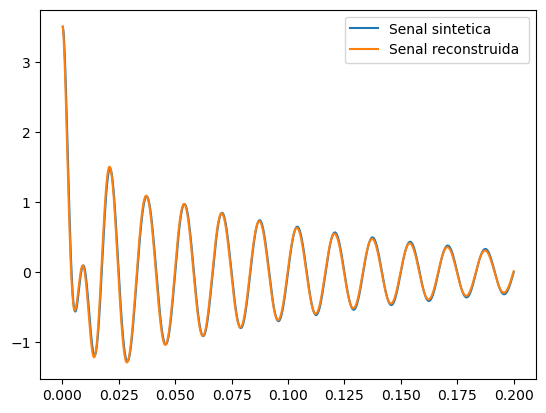

In [32]:
ceros = 0
polos = 5
t_min = 0
t_max = 0.2 # tiempo max
No_muestras = 1001 
t = np.linspace(t_min, t_max, No_muestras)[1:]
dt = (t_max - t_min)/(No_muestras - 1)
#----------------------------------------------------
noise = 0.000001 
stats_filtred = False
#----------------------------------------------------
# w = 2*np.pi*60
# omega = w  
# alfa = -8   
# senal = 1.5*np.exp(alfa*t)*np.sin(omega*t) + 3.5*np.exp(alfa*15*t)*np.sin(omega*1.5*t + np.pi/2)
#----------------------------------------------------
senal = Senal(t, noise, stats_filtred, dt)
prony(polos, senal, t, dt)